In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_theme()

In [3]:
trips19 = pd.read_csv('tripdata_2019-05.csv')
trips20 = pd.read_csv('tripdata_2020-05.csv')

/home/khodor/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Посмотрим, какие пропущенные значения есть в данных.

In [21]:
for el in trips19.columns:
    print(el, trips19[el].isna().sum())

VendorID 0
tpep_pickup_datetime 0
tpep_dropoff_datetime 0
passenger_count 0
trip_distance 0
RatecodeID 0
store_and_fwd_flag 0
PULocationID 0
DOLocationID 0
payment_type 0
fare_amount 0
extra 0
mta_tax 0
tip_amount 0
tolls_amount 0
improvement_surcharge 0
total_amount 0
congestion_surcharge 0


In [22]:
for el in trips20.columns:
    print(el, trips20[el].isna().sum())

VendorID 58891
tpep_pickup_datetime 0
tpep_dropoff_datetime 0
passenger_count 58891
trip_distance 0
RatecodeID 58891
store_and_fwd_flag 58891
PULocationID 0
DOLocationID 0
payment_type 58891
fare_amount 0
extra 0
mta_tax 0
tip_amount 0
tolls_amount 0
improvement_surcharge 0
total_amount 0
congestion_surcharge 0


На данный момент из пропущенных данных для нас интерес может представлять только колонка о количестве пассажиров.

Посмотрим на самое частое значение и заменим на него все пропущенные значения.

In [4]:
max_passengers_count = trips20['passenger_count'].value_counts().idxmax()
print("Max passengers count = ", max_passengers_count)
trips20.passenger_count = trips20.passenger_count.fillna(max_passengers_count)

Max passengers count =  1.0


Посмотрим на количество колонок, в которых встречаются данные со значением Nan.

Преобразуем формат ячеек с временем для удобства.

In [5]:
trips19['tpep_pickup_datetime'] = pd.to_datetime(trips19.tpep_pickup_datetime)
trips19['tpep_dropoff_datetime'] = pd.to_datetime(trips19.tpep_dropoff_datetime)

trips20['tpep_pickup_datetime'] = pd.to_datetime(trips20.tpep_pickup_datetime)
trips20['tpep_dropoff_datetime'] = pd.to_datetime(trips20.tpep_dropoff_datetime)

Удалим данные, в которых начало во времени находится после конца.

In [6]:
trips19 = trips19[trips19.tpep_pickup_datetime <= trips19.tpep_dropoff_datetime]
trips20 = trips20[trips20.tpep_pickup_datetime <= trips20.tpep_dropoff_datetime]

Введём новые колонки: 

1. с датой начала поездки; 

2. с часом начала и конца;

3. с днём недели начала поездки; 

4. с временем продолжительности поездки(день конца поездки игнорируем, т.к. почти все поездки будут в промежутке одного дня);

5. временем поездки в секундах;

6. средней скоростью в м/с.

In [7]:
trips19['trip_pickup_day'] = trips19.tpep_pickup_datetime.dt.day
trips19['week_day'] = trips19.tpep_pickup_datetime.dt.dayofweek
trips19['trip_pickup_hour'] = trips19.tpep_pickup_datetime.dt.hour
trips19['trip_dropoff_hour'] = trips19.tpep_dropoff_datetime.dt.hour
trips19['trip_duration'] = trips19.tpep_dropoff_datetime - trips19.tpep_pickup_datetime
trips19['trip_duration_secs'] = trips19.trip_duration.dt.seconds
trips19['average_velocity'] = (trips19['trip_distance'] * 1609.34) / trips19['trip_duration_secs']

trips20['trip_pickup_day'] = trips20.tpep_pickup_datetime.dt.day
trips20['week_day'] = trips20.tpep_pickup_datetime.dt.dayofweek
trips20['trip_pickup_hour'] = trips20.tpep_pickup_datetime.dt.hour
trips20['trip_dropoff_hour'] = trips20.tpep_dropoff_datetime.dt.hour
trips20['trip_duration'] = trips20.tpep_dropoff_datetime - trips20.tpep_pickup_datetime
trips20['trip_duration_secs'] = trips20.trip_duration.dt.seconds
trips20['average_velocity'] = (trips20['trip_distance'] * 1609.34) / trips20['trip_duration_secs']

Посмотрим, есть ли в данных нереальные случаи.

Установим ограничение для средней скорости в 162 км/ч(45 м/с) сверху и 2(м/с) снизу, а также удалим строки, в которых преодолено нулевое расстояние за ненулевое время, при этом получена некоторая сумма за поездку.

Так же удалим строки с отрицательной стоимостью поездки.

In [8]:
trips19 = trips19[trips19.average_velocity <= 45]
trips19 = trips19[trips19.average_velocity > 2]
trips19 = trips19.drop(trips19[(trips19.trip_distance == 0) & (trips19.total_amount > 0) & (trips19.trip_duration_secs > 0)].index)
trips19 = trips19[trips19.total_amount >= 0]

trips20 = trips20[trips20.average_velocity <= 45]
trips20 = trips20[trips20.average_velocity > 2]
trips20 = trips20.drop(trips20[(trips20.trip_distance == 0) & (trips20.total_amount > 0) & (trips20.trip_duration_secs > 0)].index)
trips20 = trips20[trips20.total_amount >= 0]

In [10]:
trips19

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,improvement_surcharge,total_amount,congestion_surcharge,trip_pickup_day,week_day,trip_pickup_hour,trip_dropoff_hour,trip_duration,trip_duration_secs,average_velocity
1,1,2019-05-01 00:35:54,2019-05-01 00:37:27,1,1.50,1,N,145,145,2,...,0.3,4.30,0.0,1,2,0,0,00:01:33,93,25.957097
3,1,2019-05-01 00:44:57,2019-05-01 00:50:11,1,0.70,1,N,161,161,2,...,0.3,8.80,2.5,1,2,0,0,00:05:14,314,3.587701
4,1,2019-05-01 00:59:48,2019-05-01 01:10:22,1,2.00,1,N,163,141,1,...,0.3,15.30,2.5,1,2,0,1,00:10:34,634,5.076782
7,1,2019-05-01 00:23:20,2019-05-01 00:32:57,1,2.50,1,N,260,56,2,...,0.3,11.30,0.0,1,2,0,0,00:09:37,577,6.972877
8,1,2019-05-01 00:35:54,2019-05-01 00:47:49,1,2.80,1,N,56,226,2,...,0.3,12.80,0.0,1,2,0,0,00:11:55,715,6.302310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7565253,2,2019-05-31 23:40:41,2019-05-31 23:45:16,1,0.44,1,N,163,142,2,...,0.3,7.80,2.5,31,4,23,23,00:04:35,275,2.574944
7565254,2,2019-05-31 23:47:35,2019-05-31 23:57:15,1,1.39,1,N,43,229,1,...,0.3,14.16,2.5,31,4,23,23,00:09:40,580,3.856867
7565256,2,2019-05-31 23:22:08,2019-05-31 23:58:35,3,15.69,1,N,231,153,1,...,0.3,62.88,2.5,31,4,23,23,00:36:27,2187,11.545745
7565257,2,2019-05-31 23:10:12,2019-05-31 23:17:56,1,1.42,1,N,262,237,1,...,0.3,14.12,2.5,31,4,23,23,00:07:44,464,4.925135


### Вот тут ниже надо будет графики в один ряд нарисовать.

In [13]:
#xparam = 'week_day'
#yparam = 'total_amount'

#pl19 = sns.relplot(
#    data=trips19, x=xparam, y=yparam,
#)
#pl20 = sns.relplot(
#    data=trips20, x=xparam, y=yparam,
#)

#x_lim = max(trips19[xparam].max(), trips20[xparam].max())
#y_lim = max(trips19[yparam].max(), trips20[yparam].max())
#pl19.set(xticks=(0, x_lim), yticks=(0, y_lim))
#pl20.set(xticks=(0, x_lim), yticks=(0, y_lim))

Построим гистограммы по дню поездки, где понедельник = 0, воскресенье = 6.

In [21]:
trips19.week_day.value_counts()

4    1219877
3    1212142
2    1182718
5     922303
1     920098
6     823923
0     806773
Name: week_day, dtype: int64

### Тут вот непонятно, почему при наличии данных в 4й день, на графике не рисуется. Надо разобраться.

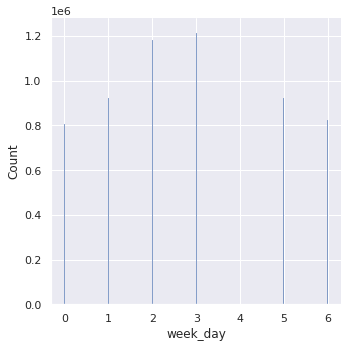

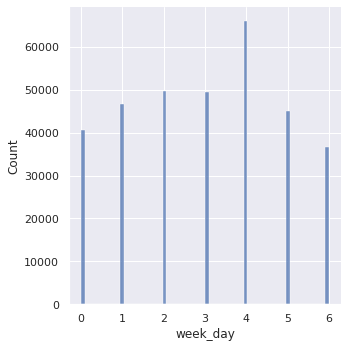

In [15]:
sns.displot(trips19, x='week_day')
sns.displot(trips20, x='week_day')

Посмотрим на распределение по каждому дню недели.

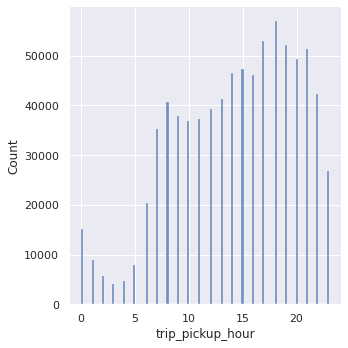

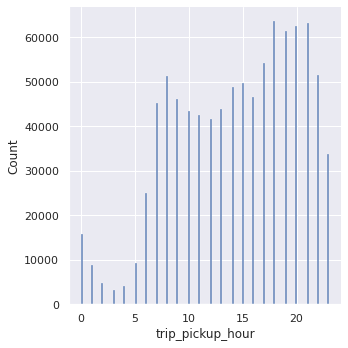

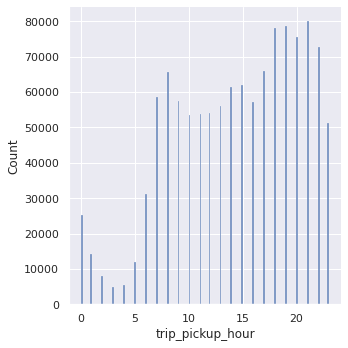

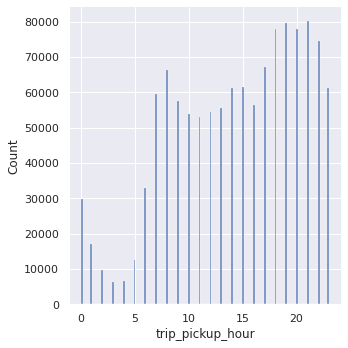

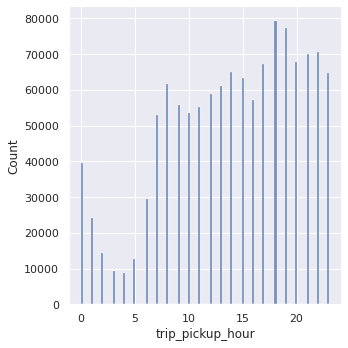

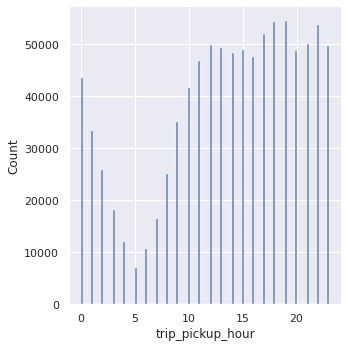

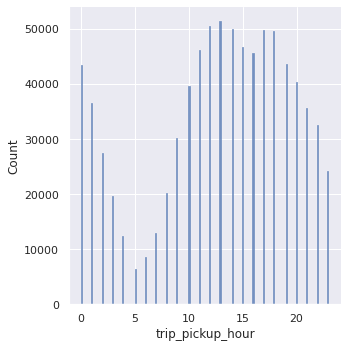

In [16]:
for i in range(7):
    plt19 = sns.displot(trips19[trips19.week_day == i].trip_pickup_hour)    
    #plt19.ax = 'asd'

По дате начала поездки.

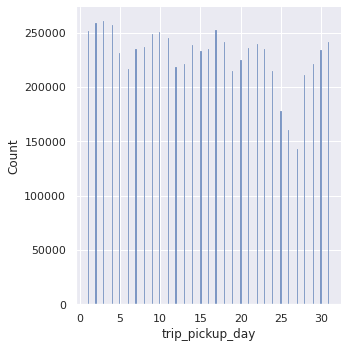

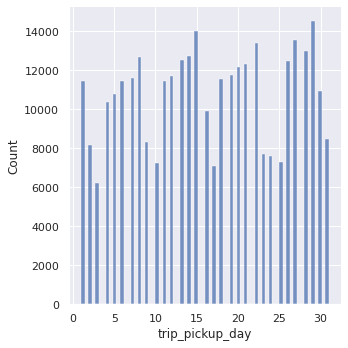

In [23]:
sns.displot(trips19, x='trip_pickup_day')
sns.displot(trips20, x='trip_pickup_day')

По часу начала и конца.

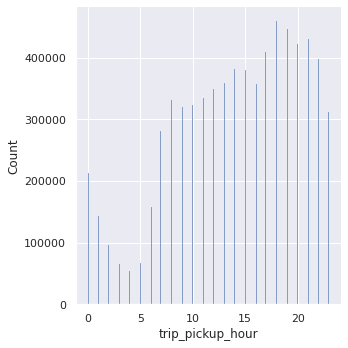

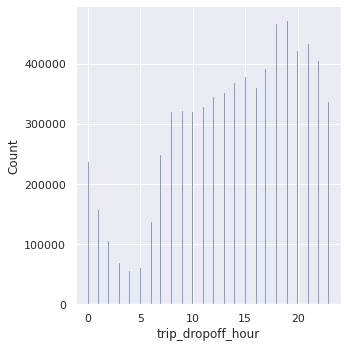

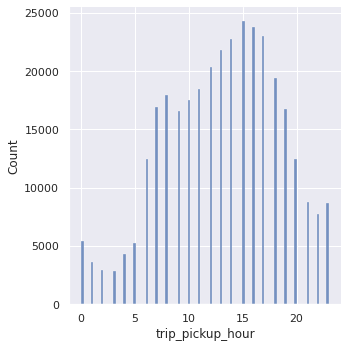

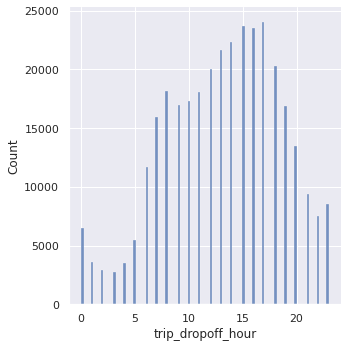

In [28]:
sns.displot(trips19, x='trip_pickup_hour')
sns.displot(trips19, x='trip_dropoff_hour')

sns.displot(trips20, x='trip_pickup_hour')
sns.displot(trips20, x='trip_dropoff_hour')